In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from models import *
from datalib import *
import config.config_create_trajectory as config

import csv
import json
from decimal import Decimal, ROUND_DOWN, ROUND_UP
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

script_starting_time = t.time()

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
start_time = t.time()
print("Reading demonstration data")

position_datasets = []
velocity_datasets = []
orientation_datasets = []
force_datasets = []
torque_datasets = []

for demo in config.demos:
    print(f'Reading demonstration file {demo}')
    franka_reader = FrankaStateReader(demo)

    position_dataset = PositionDataSet()
    orientation_dataset = PositionDataSet()
    velocity_dataset = PositionDataSet()
    force_dataset = PositionDataSet()
    torque_dataset = PositionDataSet()

    for i in range(len(franka_reader.msgs)):
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value

        position_dataset.append(PositionDataPoint(time, franka_state.position))
        velocity_dataset.append(PositionDataPoint(time, franka_state.velocity))
        orientation_dataset.append(PositionDataPoint(time, franka_state.euler_angles))
        force_dataset.append(PositionDataPoint(time, franka_state.force_external))
        torque_dataset.append(PositionDataPoint(time, franka_state.torque_external))
        
    position_dataset.align_time()
    velocity_dataset.align_time()
    orientation_dataset.align_time()
    force_dataset.align_time()
    torque_dataset.align_time()

    position_datasets.append(position_dataset)
    velocity_datasets.append(velocity_dataset)
    orientation_datasets.append(orientation_dataset)
    force_datasets.append(force_dataset)
    torque_datasets.append(torque_dataset)

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo12.bag
--- 9.540226697921753 seconds ---
Done


In [3]:
start_time = t.time()
print("Initializing datasets handle")

impact_intervals = []
for i in range(len(config.impact_intervals)):
    delayed_demo_impact_intervals = config.impact_intervals[i]
    impact_detection_delays = config.impact_detection_delays[i]
        
    demo_impact_intervals = []
    for delayed_impact_interval in delayed_demo_impact_intervals:
        impact_interval = ()
        for j in range(len(delayed_impact_interval)):
            impact_interval += (delayed_impact_interval[j] - impact_detection_delays[j],)
        demo_impact_intervals.append(impact_interval)
    impact_intervals.append(demo_impact_intervals)

dh = RobotStateDataSetsHandle(position_datasets, velocity_datasets, orientation_datasets, force_datasets, torque_datasets, impact_intervals)

dh.align_position_data(trim=True)
dh.align_orientation_data(trim=True)
dh.align_force_data(trim=True)
dh.align_torque_data(trim=True)

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Initializing datasets handle
--- 2.9264330863952637 seconds ---
Done


In [4]:
extender = config.force_extender
dh.extend_force_data(extender)
dh.extend_torque_data(extender)

In [5]:
start_time = t.time()
print("Preparing data for phase comparison")

force_phase_data = []
torque_phase_data = []

for phase in range(dh.n_phases):
    
    force_phase_data.append([])
    torque_phase_data.append([])
        
    for trajectory_handle in dh.force_trajectory_handles:
        data = trajectory_handle.phase_data[phase]
        force_phase_data[phase].append(data.get_index(0).copy())
    
    for trajectory_handle in dh.torque_trajectory_handles:
        data = trajectory_handle.phase_data[phase]
        torque_phase_data[phase].append(data.get_index(0).copy())
        
    for i in range(len(force_phase_data[phase])):
        time_shift = 0
        force_phase_data[phase][i].align_time(force_phase_data[phase][i][0].time + time_shift)
        torque_phase_data[phase][i].align_time(torque_phase_data[phase][i][0].time + time_shift)
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Preparing data for phase comparison
--- 0.1882929801940918 seconds ---
Done


<IPython.core.display.Javascript object>


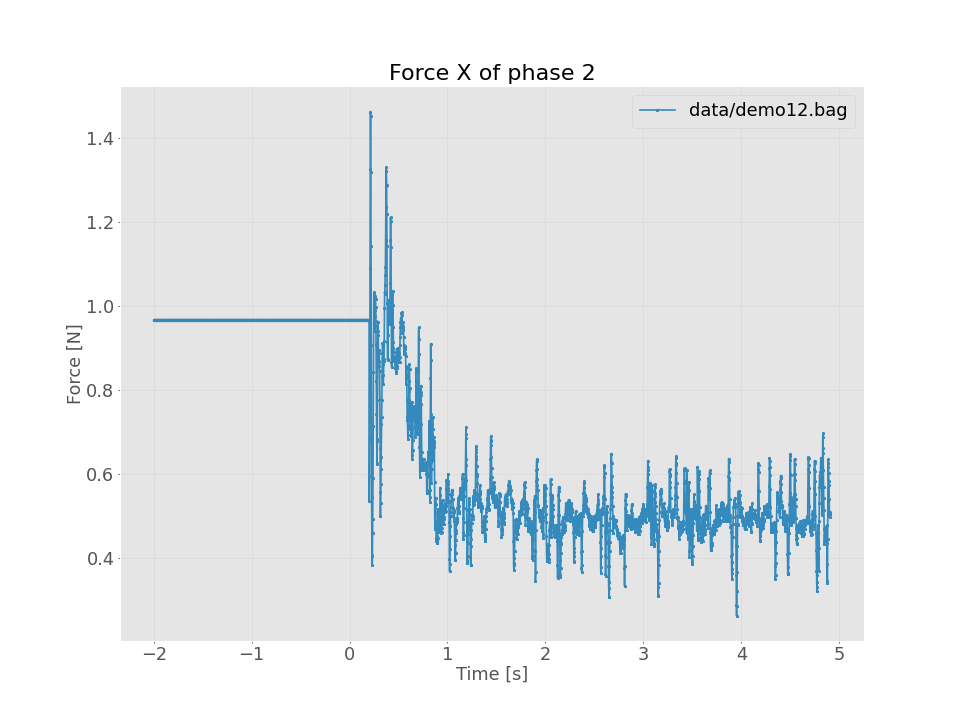

<IPython.core.display.Javascript object>


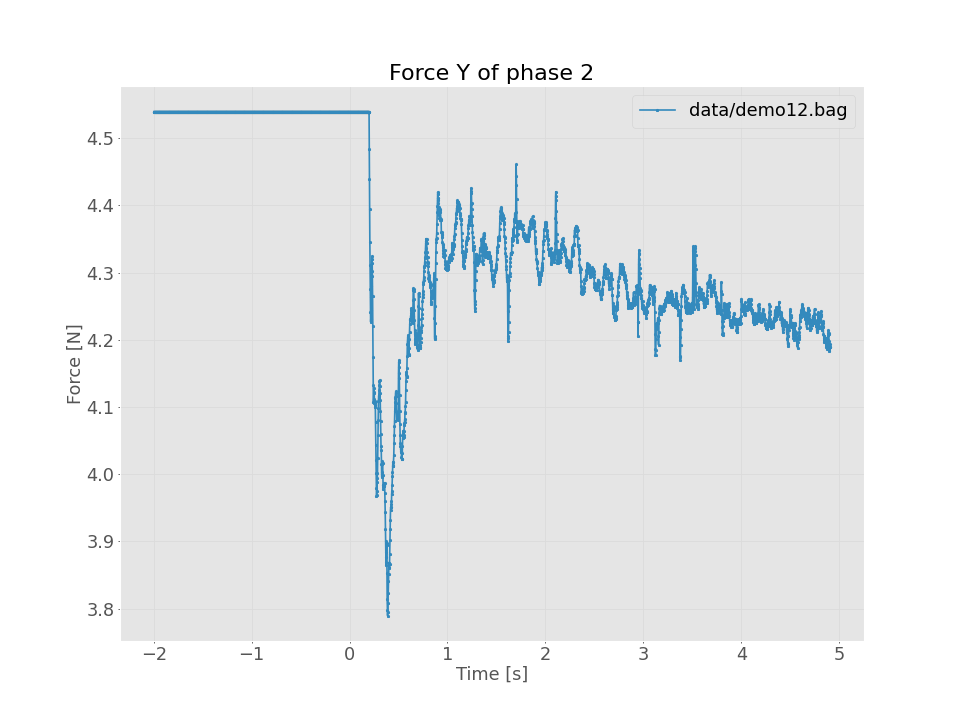

<IPython.core.display.Javascript object>


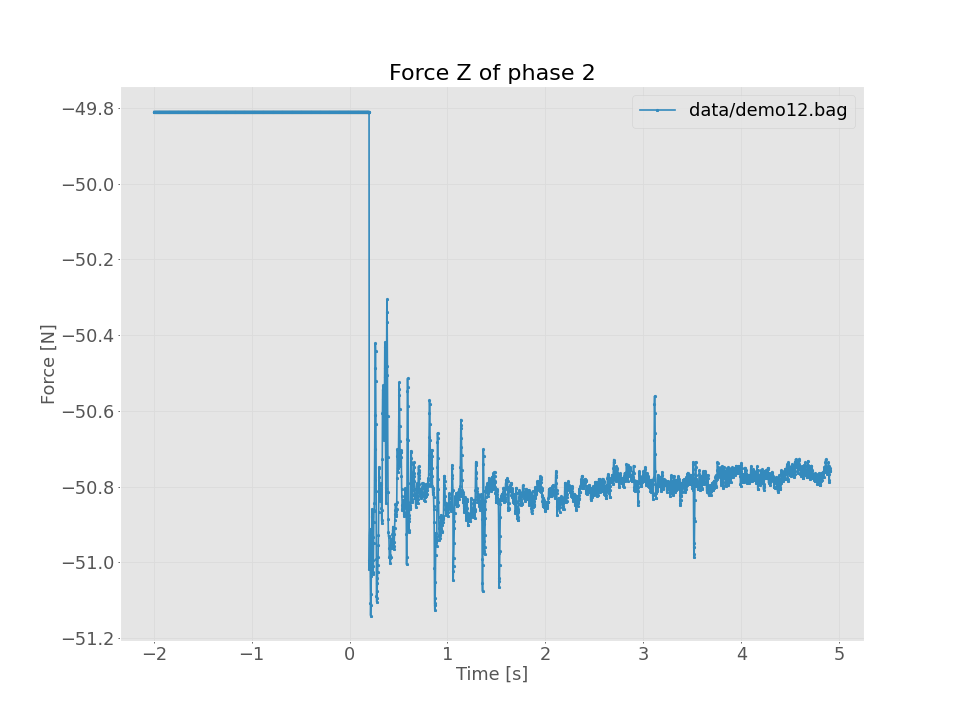

In [6]:
# Plot force data per phase
for j in range(3):
    for phase in [1]:
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        for i in range(len(force_phase_data[phase])):
            data = force_phase_data[phase][i].get_index(j)
            plt.plot(data.time, data.value,f'C{i+1}-*',linewidth=config.linewidth, markersize=config.markersize3,label=f'{config.demos[i]}')
        
#         data = force_evaluated_data[phase].get_index(j)
#         plt.plot(data.time, data.value,'C0-*',linewidth=config.linewidth, markersize=config.markersize2,label='ProMP')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Force [N]',fontsize=config.fontsize2)
        plt.title(f'Force {config.variable_labels[j]} of phase {phase+1}',fontsize=config.fontsize1)

<IPython.core.display.Javascript object>


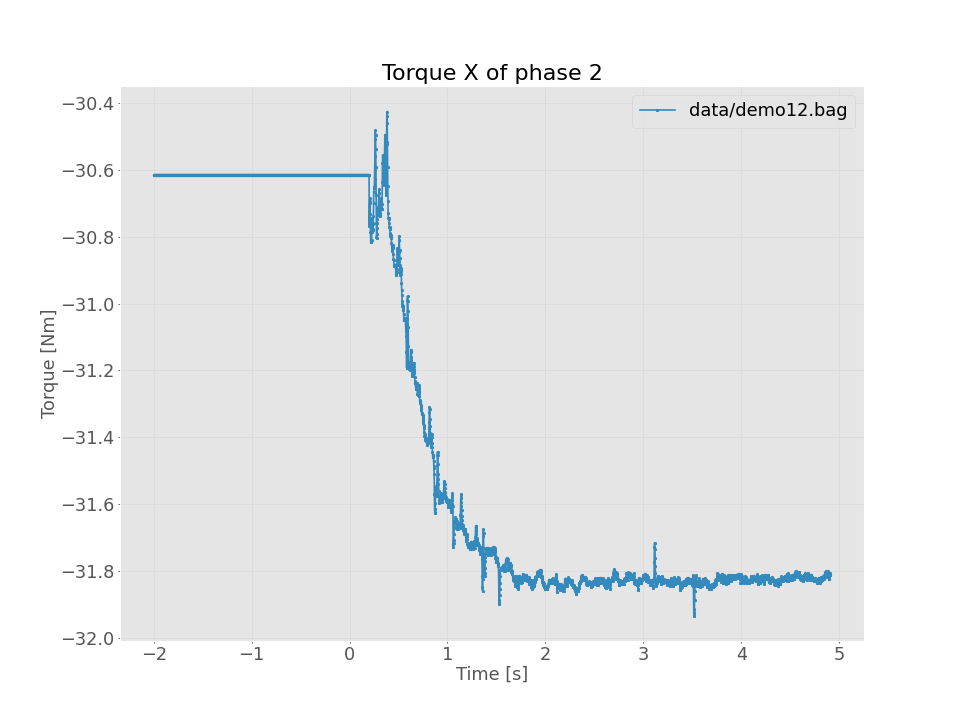

<IPython.core.display.Javascript object>


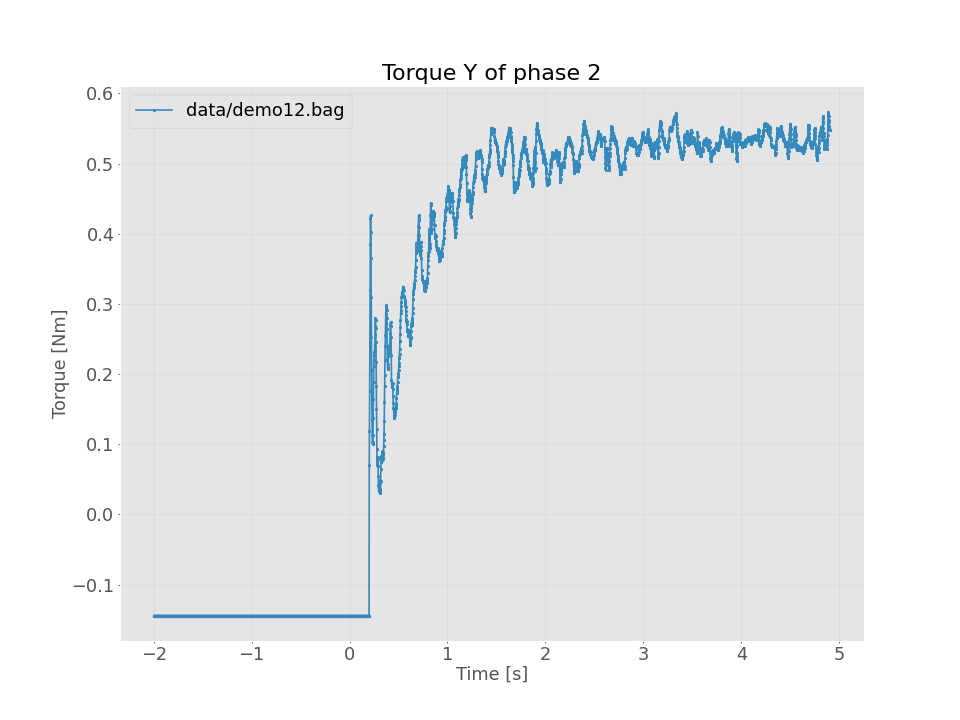

<IPython.core.display.Javascript object>


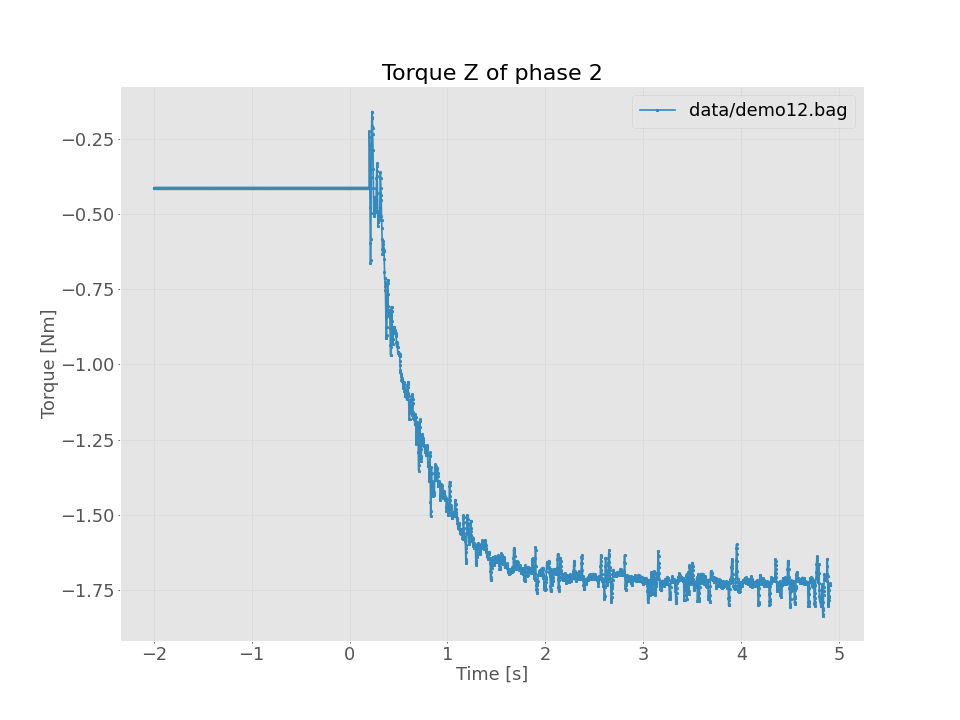

In [7]:
# Plot torque data per phase
for j in range(3):
    for phase in [1]:
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        for i in range(len(torque_phase_data[phase])):
            data = torque_phase_data[phase][i].get_index(j)
            plt.plot(data.time, data.value,f'C{i+1}-*',linewidth=config.linewidth, markersize=config.markersize3,label=f'{config.demos[i]}')
        
#         data = force_evaluated_data[phase].get_index(j)
#         plt.plot(data.time, data.value,'C0-*',linewidth=config.linewidth, markersize=config.markersize2,label='ProMP')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Torque [Nm]',fontsize=config.fontsize2)
        plt.title(f'Torque {config.variable_labels[j]} of phase {phase+1}',fontsize=config.fontsize1)